In [1]:
%matplotlib inline

In [2]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

plt.style.use('bmh')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['figure.figsize'] = '7, 5'

In [3]:
def make_figure_axes(x, y, fig_number=1, fig_size=8):
    '''
    Creates a set of 3 axes to plot 2D function + marginals
    '''
    # determine max size
    size_x = x.max() - x.min()
    size_y = y.max() - y.min()
    max_size = max(size_x, size_y)
    min_size = min(size_x, size_y)

    if size_x >= size_y:
        fig_size_x = fig_size
        fig_size_y = (0.12 * fig_size_x +
                      0.65 * fig_size_x * min_size / max_size +
                      0.02 * fig_size_x +
                      0.18 * fig_size_x +
                      0.03 * fig_size_x)
        rect_main = [0.12,
                     0.12 * fig_size_x / fig_size_y,
                     0.65,
                     0.65 * fig_size_x * min_size / max_size / fig_size_y]
        rect_x = [0.12, ((0.12 + 0.65 * min_size / max_size + 0.02) *
                         fig_size_x / fig_size_y),
                  0.65, 0.18 * fig_size_x / fig_size_y]
        rect_y = [0.79, 0.12 * fig_size_x / fig_size_y,
                  0.18, 0.65 * fig_size_x * min_size / max_size / fig_size_y]
    else:
        fig_size_y = fig_size
        fig_size_x = (0.12 * fig_size_y +
                      0.65 * fig_size_y * min_size / max_size +
                      0.02 * fig_size_y +
                      0.18 * fig_size_y +
                      0.03 * fig_size_y)
        rect_main = [0.12 * fig_size_y / fig_size_x,
                     0.12,
                     0.65 * fig_size_y * min_size / max_size / fig_size_x,
                     0.65]
        rect_x = [0.12 * fig_size_y / fig_size_x, 0.79,
                  0.65 * fig_size_y * min_size / max_size / fig_size_x, 0.18]
        rect_y = [((0.12 + 0.65 * min_size / max_size + 0.02) *
                   fig_size_y / fig_size_x), 0.12,
                  0.18 * fig_size_y / fig_size_x, 0.65]

    fig = plt.figure(fig_number, figsize=(fig_size_x, fig_size_y))
    fig.clf()

    ax_main = fig.add_axes(rect_main)
    ax_marginal_x = fig.add_axes(rect_x, xticklabels=[])
    ax_marginal_y = fig.add_axes(rect_y, yticklabels=[])

    return ax_main, ax_marginal_x, ax_marginal_y


def plot_distribution(x, y, z, cmap='viridis'):
    x_limits = (x.min(), x.max())
    y_limits = (y.min(), y.max())

    ax_main, ax_marginal_x, ax_marginal_y = make_figure_axes(x, y)
    ax_main.pcolormesh(x, y, z, cmap=cmap)

    marginal_x = np.sum(z, axis=1)
    ax_marginal_x.plot(x[:,0], marginal_x)
    [l.set_rotation(-90) for l in ax_marginal_y.get_xticklabels()]

    marginal_y = np.sum(z, axis=0)
    ax_marginal_y.plot(marginal_y, y[0])

    ax_main.set_xlim(x_limits)
    ax_main.set_ylim(y_limits)

    ax_marginal_x.set_xlim(x_limits)
    ax_marginal_y.set_ylim(y_limits)
    return ax_main, ax_marginal_x, ax_marginal_y

# ¿Por qué necesitamos MCMC?

Como vimos en un demo anterior, calcular la probabilidad posterior para un cubo de 200x200x200 tomó aproximadamente 2 min en un laptop bastante moderno para estándares actuales. Agregar otra dimensión de 200, significaría ~6.5 horas de procesamiento. Además, el prior y la verosimilitud en dicho caso eran relativamente fáciles de calcular... en un caso real podrían ser aún más complicadas, y con más parámetros libres.

Sin embargo, si miramos una de las figuras del demo anterior encontramos que la mayor parte del tiempo se "desperdicia" calculando la posterior en regiones de muy muy baja probabilidad.

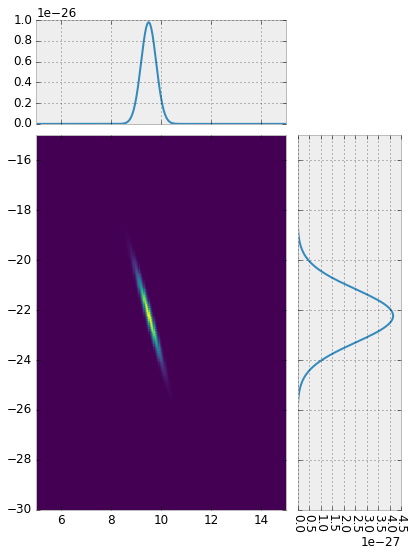

In [4]:
Image("demo_anterior.png")

Lo que deseamos es poder construir las probabilidades posteriores, para eso, necesitamos un método que nos permita **obtener muestras que tengan la misma distribución que otra que no está normalizada pero que puede ser evaluada en puntos arbitrarios**. --> Metrópolis es uno de ellos (que ya implementamos en 1D), la familia más amplia de métodos para eso, se llama MCMC.

Una de las ventajas más importantes de estos métodos, es que no *"desperdician"* tanto tiempo en sectores de baja probabilidad, sino que se concentran en muestrear las areas de alta probabilidad.

Veamos una implementación de Metropolis para este problema en 2D (en el cual no vale la pena usarlo, pues es más fácil el método demostrado anteriormente que a pesar de desperdiciar cálculo, es aun rapido para el tamaño del problema.

Partiremos por repetir el código del demo anterior para reproducir el problema.

In [5]:
np.random.seed(44)
N = 20
x_sample = np.random.uniform(3, 6, size=N)
y_sample = 2.5 + 3.4 * x_sample + np.random.normal(0, 1.5, size=N)

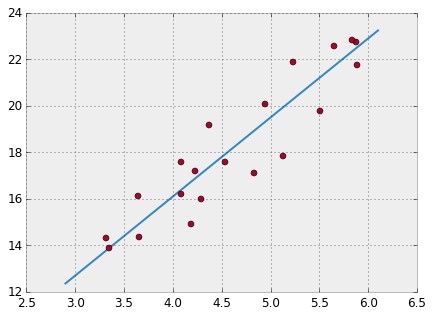

In [6]:
x = np.linspace(2.9, 6.1, 10)
y = 2.5 + 3.4 * x
plt.plot(x, y, ls='-', marker='None', mfc='None')
plt.plot(x_sample, y_sample, ls='None', marker='o')

In [7]:
def prior(beta, params):
    beta0, beta1 = beta
    mu0, sigma0, mu1, sigma1 = params
    S = -1. / 2 * ((beta0 - mu0)**2 / sigma0**2 + (beta1 - mu1)**2 / sigma1**2)
    P = np.exp(S) / (2 * np.pi * sigma0 * sigma1)
    return P

def fill_prior(beta0_grid, beta1_grid, prior_params):
    output = np.zeros(beta0_grid.shape)
    ni, nj = beta0_grid.shape
    for i in range(ni):
        for j in range(nj):
            output[i, j] = prior([beta0_grid[i,j], beta1_grid[i,j]], prior_params)
    return output

def likelihood(beta, data):
    beta0, beta1 = beta
    x, y = data
    try:
        N = len(x)
    except:
        N = 1
    S = np.sum((y - beta0 - beta1 * x)**2)
    L = (2 * np.pi * 1.5**2)**(-N / 2.) * np.exp(-S / 2 / 1.5**2)
    return L

def fill_likelihood(beta0_grid, beta1_grid, data):
    output = np.zeros(beta0_grid.shape)
    ni, nj = beta0_grid.shape
    for i in range(ni):
        for j in range(nj):
            output[i, j] = likelihood([beta0_grid[i,j], beta1_grid[i,j]], data)
    return output

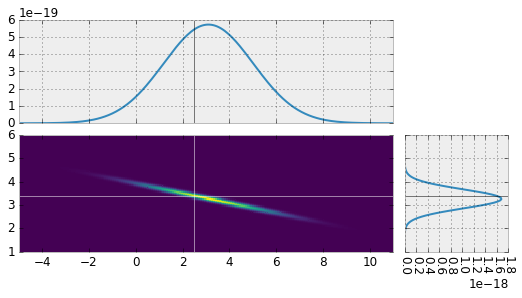

In [8]:
beta0_grid, beta1_grid = np.mgrid[-5:11:201j, 1:6:101j] # Grilla suficientemente grande
dx = 16 / 200
dy = 5 / 100

prior_params = [1, 100, 10, 100]
prior_grid = fill_prior(beta0_grid, beta1_grid, prior_params)
likelihood_grid = fill_likelihood(beta0_grid, beta1_grid, [x_sample, y_sample])

ax_main, ax_0, ax_1 = plot_distribution(beta0_grid, beta1_grid, likelihood_grid * prior_grid)
ax_main.axvline(2.5, lw=0.5, color='w')
ax_main.axhline(3.4, lw=0.5, color='w')
ax_1.axhline(3.4, lw=.5, color='k')
ax_0.axvline(2.5, lw=.5, color='k')

In [9]:
# Y la normalizacion como la integral simple de esta funcion den 2D
P_E = np.sum(likelihood_grid * prior_grid) * dx * dy
print "La normalizacion es P(E) = ", P_E

La normalizacion es P(E) =  1.36920180793e-19


# Demo Metrópolis

Aca realmente comienza el nuevo demo.

Nuestro objetivo es obtener la distribucion 2D de los parámetros, sin tener que evaluarla en todos los puntos de una grilla predefinida (pues desperdicia muchos cálculos).

In [10]:
prior_params = [1, 100, 10, 100]
data = [x_sample, y_sample]

def paso_metropolis(p0, d=.3, prior_params=prior_params):
    x0, y0 = p0
    rx = np.random.uniform(low=-1, high=1)
    ry = np.random.uniform(low=-1, high=1)
    xp = x0 + d * rx
    yp = y0 + d * ry
    posterior_p0 = prior([x0, y0], prior_params) * likelihood([x0, y0], data)
    posterior_pprueba = prior([xp, yp], prior_params) * likelihood([xp, yp], data)
    if (posterior_pprueba / posterior_p0) > np.random.uniform(0, 1):
        p0 = [xp, yp]
    return p0

In [38]:
N_muestra = 50000 # Notar que son 2k estimaciones vs. 20k
muestra_metropolis = np.zeros((N_muestra, 2))

p0 = [4, 5]
rechazados = 0
muestra_metropolis[0] = p0
for i in range(1, N_muestra):
    muestra_metropolis[i] = paso_metropolis(muestra_metropolis[i-1], d=3.) # intentar 0.1, 0.5, 1., 3., 10.
    if muestra_metropolis[i][0] == muestra_metropolis[i-1][0]:
        rechazados += 1

print "Se rechazadon {:3.5f}% de los pasos.".format(rechazados / N_muestra / 100)

Se rechazadon 0.00968% de los pasos.


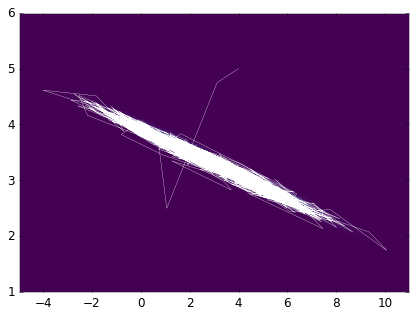

In [39]:
plt.pcolormesh(beta0_grid, beta1_grid, likelihood_grid * prior_grid, cmap='viridis')
plt.xlim(-5, 11)
plt.ylim(1,  6)
plt.plot(muestra_metropolis[:,0], muestra_metropolis[:,1], marker='None', ls='-', lw=0.3, color='w')

# Probabilidad marginal de $\beta_1$

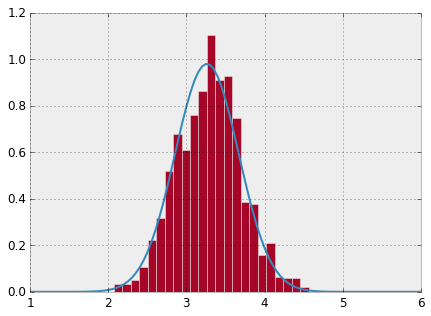

In [40]:
prob_beta1 = np.sum(likelihood_grid * prior_grid, axis=0) * dx / P_E
plt.plot(beta1_grid[0], prob_beta1)

_ = plt.hist(muestra_metropolis[:,1], bins=30, normed=True)

# Plot de diagnóstico

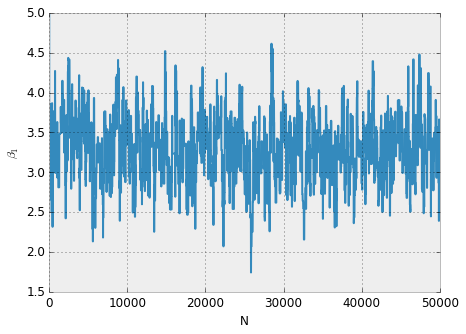

In [41]:
plt.plot(muestra_metropolis[:,1])
# plt.xlim(0, 500)
plt.ylabel(r'$\beta_1$')
plt.xlabel('N')

### Metrópolis requiere de calibracion en el parametro d, y el punto de partida para la busqueda.

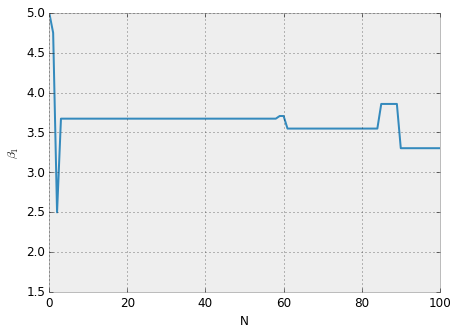

In [42]:
plt.plot(muestra_metropolis[:,1])
plt.xlim(0, 100)
plt.ylabel(r'$\beta_1$')
plt.xlabel('N')

# Algoritmos más sofisticados

Hamiltonian Monte Carlo, No U-turn Hamilitonian Monte Carlo (NUTS).

Muy pocas implementaciones aun, son métodos muy recientes. Veamos el módulo `pymc3` (~2013).

Nota: Requiere instalacion no standard. Ver instrucciones [aqui](https://github.com/pymc-devs/pymc3).

In [16]:
import pymc3 as pm

In [17]:
with pm.Model() as basic_model:
    
    # Priors for unknown model parameters
    beta0 = pm.Normal('beta0', mu=1, sd=100)
    beta1 = pm.Normal('beta1', mu=10, sd=100)

    # Expected value of outcome
    y_out = beta0 + beta1 * x_sample

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=y_out, sd=1.5, observed=y_sample)

# MAP

Una de las cosas que `pymc3` puede hacer rápidamente es calcular el MAP (Maximum a Posteriori), usando técnicas de optimizacion.

In [18]:
map_estimate = pm.find_MAP(model=basic_model)

print(map_estimate)

{'beta1': array(3.261652459748924), 'beta0': array(3.102770064337099)}


Ahora creamos una muestra usando el algoritmo NUTS (por defecto).

In [19]:
with basic_model:
    trace = pm.sample(5000, start=map_estimate) 

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta0
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta1
 [-----------------100%-----------------] 5000 of 5000 complete in 2.9 sec

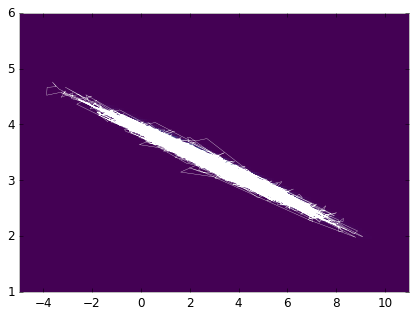

In [20]:
plt.pcolormesh(beta0_grid, beta1_grid, likelihood_grid * prior_grid, cmap='viridis')
plt.xlim(-5, 11)
plt.ylim(1,  6)
plt.plot(trace.beta0, trace.beta1, marker='None', ls='-', lw=0.3, color='w')

# Plots de diagnostico

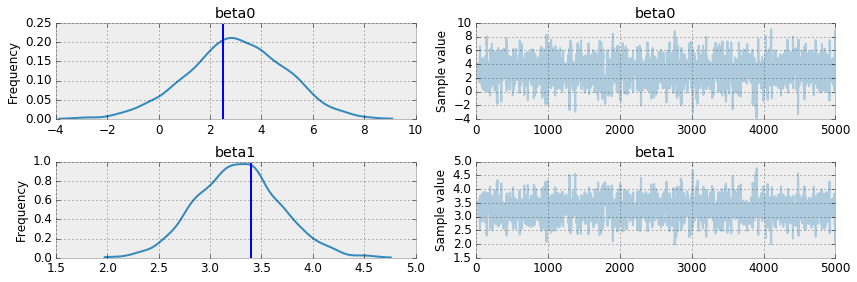

In [21]:
[[ax11, ax12], [ax21, ax22]] = pm.traceplot(trace)
ax11.axvline(2.5)
ax21.axvline(3.4)

(1.5, 5.0)

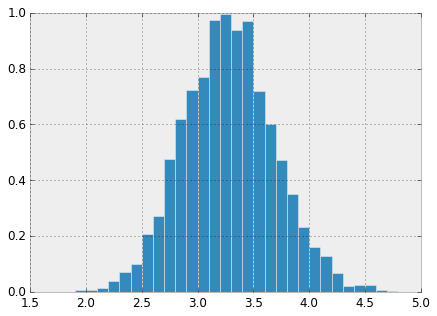

In [22]:
h, _, _ = plt.hist(trace.beta1, bins=np.arange(1, 5, 0.1), normed=True)
plt.xlim(1.5, 5.)

# Evidencia

El cálculo de la evidencia implica el cálculo de una integral multidimensional lo cual puede tomar demasiado tiempo. Una estrategia a seguir, es la de "Importance Sampling", que vimos hace tiempo atrás.

En este caso la Evidencia se puede calcular de la integral en 2D de la posterior. Recordemos que ya la calculamos.

In [23]:
print "La evidencia es = ", P_E

La evidencia es =  1.36920180793e-19


Calculemsla de nuevo usando importance sampling.

In [24]:
from scipy.stats import multivariate_normal

In [43]:
# Usaremos una gaussiana 2D
# los parametros adecuados los podemos estimar de la muestra obtenida usando pymc3 o Metropolis.
mu = [2.5, 3.4]
sigma = [[2.5,-.5],
         [-.5,.5]] # Ver que pasa con covarianza = -0.5
nd_normal = multivariate_normal(mu, sigma)

In [44]:
N_sample = 5000
random_points = nd_normal.rvs(N_sample)
suma = 0
for p in random_points:
    posterior = likelihood(p, [x_sample, y_sample]) * prior(p, prior_params)
    suma += posterior / nd_normal.pdf(p)
print suma / N_sample

1.4777660363e-19


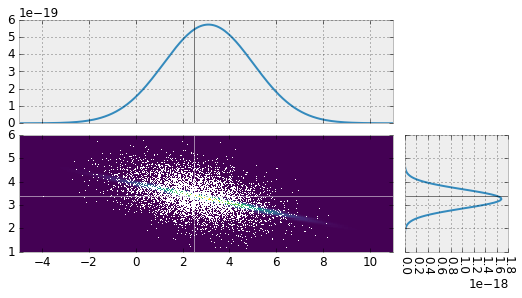

In [45]:
ax_main, ax_0, ax_1 = plot_distribution(beta0_grid, beta1_grid, likelihood_grid * prior_grid)
ax_main.axvline(2.5, lw=0.5, color='w')
ax_main.axhline(3.4, lw=0.5, color='w')
ax_1.axhline(3.4, lw=.5, color='k')
ax_0.axvline(2.5, lw=.5, color='k')

ax_main.plot(random_points[:,0], random_points[:,1], 'w,')